# MNIST Digit Classification: 2-Layer Neural Network Implementation w/ 300 Hidden Units


**Project:** Digit Detection System

**Class:** CPT_S 437 Machine Learning

**Team Members:** Molly Iverson, Caitlin Graves, Chandler Juego

# Summary

## Model Overview

This implementation focuses on a simple yet foundational two-layer neural network designed to classify handwritten digits from the MNIST dataset. The goal was to develop a basic neural network that can recognize and classify individual digits with reasonable accuracy.

## Dataset

Source: MNIST (Modified National Institute of Standards and Technology) Dataset

Description: Handwritten digit images

Dimensions: 28x28 pixel grayscale images

Classes: 10 digits (0-9)

Training Set Size: 60,000 images

Test Set Size: 10,000 images

## Network Architecture

Input Layer: 784 neurons (28x28 flattened image)

Hidden Layer: 300 neurons with ReLU activation

Output Layer: 10 neurons with Softmax activation

## Techniques

### Preprocessing Data
1. Pixel Normalization: Scaled pixel values from [0, 255] to [0, 1]

2. One-Hot Encoding: Converted integer labels to categorical vectors

### Model Techniques
1. Activation Functions
- Hidden Layer: ReLU (Rectified Linear Unit)
  - If input is negative: output is 0
  - If input is positive: output is the input itself
  - Unlike sigmoid/tanh, ReLU doesn't "squash" positive values
  - Simple mathematical operation
  - Very fast to compute
  - Low computational overhead

- Output Layer: Softmax
  - Provides probabilistic interpretation of classification
  - Ensures output probabilities sum to 1

2. Weights Initialization
- He Initialization
  - Specifically designed for ReLU activation
  - Helps prevent vanishing/exploding gradients: values become too small/too large
  - Improves initial model convergence

3. Loss Function
- Cross-Entropy Loss
  - Measures how well predicted probabilities match true labels and punishes confident wrong predictions more heavily
  - More suitable for multi-class classification
  - Provides better gradient information

4. Optimization Strategies
- Mini-Batch Gradient Descent
  - Improved training stability
- Learning Rate Decay
  - Dynamically adjusted learning rate






## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import kagglehub
import struct
from array import array


## Load MNIST Dataset

In [ ]:
# Download MNIST dataset
#input_path = kagglehub.dataset_download('hojjatk/mnist-dataset')
# Download the Rotated MNIST dataset
input_path = kagglehub.dataset_download('saiteja0101/rotated-mnist')
train_file = input_path + '/mnist_all_rotation_normalized_float_train_valid.amat'
test_file = input_path + '/mnist_all_rotation_normalized_float_test.amat'

print('Path to dataset files:', input_path)

#training_images_filepath = input_path + '/train-images.idx3-ubyte'
#training_labels_filepath = input_path + '/train-labels.idx1-ubyte'
#test_images_filepath = input_path + '/t10k-images.idx3-ubyte'
#test_labels_filepath = input_path + '/t10k-labels.idx1-ubyte'

# Function to load images
'''
def load_images(img_path):
    with open(img_path, 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError(f"Invalid magic number {magic} in {img_path}")
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(size, rows * cols)
    return images

# Function to load labels
def load_labels(lbl_path):
    with open(lbl_path, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError(f"Invalid magic number {magic} in {lbl_path}")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels
'''

# Function to load .amat data
# Load and preprocess the dataset
def load_amat(file_path):
    data = np.loadtxt(file_path)
    X = data[:, :-1]  # All columns except the last are features (flattened image)
    y = data[:, -1]   # The last column is the label
    return X, y

# Load data
X_train, y_train = load_amat(test_file)
X_test, y_test = load_amat(train_file)

# Normalize pixel values (0-255 -> 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Path to dataset files: /root/.cache/kagglehub/datasets/saiteja0101/rotated-mnist/versions/1
X_train shape: (50000, 784)
y_train shape: (50000,)
X_test shape: (12000, 784)
y_test shape: (12000,)


## Preprocess Labels

In [ ]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Print example of one-hot encoded labels
print("Example of one-hot encoded labels:")
print(y_train_onehot[:5])


Example of one-hot encoded labels:
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


## Initialize the Neural Network Parameters

In [ ]:
# Define network architecture
input_size = 784  # 28x28 flattened
hidden_size = 300  # Number of neurons in the hidden layer
output_size = 10   # Number of classes (digits 0-9)

# Initialize weights and biases
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

# Print parameter shapes
print("W1 shape:", W1.shape)
print("b1 shape:", b1.shape)
print("W2 shape:", W2.shape)
print("b2 shape:", b2.shape)


W1 shape: (784, 300)
b1 shape: (1, 300)
W2 shape: (300, 10)
b2 shape: (1, 10)


## Forward and Backward Propagation

In [ ]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred)) / m

# Improved weight initialization
def he_init(shape):
    return np.random.randn(*shape) * np.sqrt(2 / shape[0])

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Backward propagation
def backward_propagation(X, y, Z1, A1, Z2, A2, W1, W2):
    m = X.shape[0]

    # Softmax + Cross-Entropy derivative
    dZ2 = A2 - y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # ReLU derivative
    dZ1 = np.dot(dZ2, W2.T) * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2

## Training

Epoch 10/200, Loss: 2.2948, Train Accuracy: 11.34%
Epoch 20/200, Loss: 2.2945, Train Accuracy: 11.34%
Epoch 30/200, Loss: 2.2943, Train Accuracy: 11.34%
Epoch 40/200, Loss: 2.2941, Train Accuracy: 11.34%
Epoch 50/200, Loss: 2.2939, Train Accuracy: 11.34%
Epoch 60/200, Loss: 2.2938, Train Accuracy: 11.34%
Epoch 70/200, Loss: 2.2937, Train Accuracy: 11.34%
Epoch 80/200, Loss: 2.2936, Train Accuracy: 11.34%
Epoch 90/200, Loss: 2.2935, Train Accuracy: 11.34%
Epoch 100/200, Loss: 2.2934, Train Accuracy: 11.34%
Epoch 110/200, Loss: 2.2934, Train Accuracy: 11.34%
Epoch 120/200, Loss: 2.2933, Train Accuracy: 11.34%
Epoch 130/200, Loss: 2.2932, Train Accuracy: 11.34%
Epoch 140/200, Loss: 2.2932, Train Accuracy: 11.34%
Epoch 150/200, Loss: 2.2931, Train Accuracy: 11.34%
Epoch 160/200, Loss: 2.2930, Train Accuracy: 11.34%
Epoch 170/200, Loss: 2.2930, Train Accuracy: 11.34%
Epoch 180/200, Loss: 2.2929, Train Accuracy: 11.34%
Epoch 190/200, Loss: 2.2929, Train Accuracy: 11.34%
Epoch 200/200, Loss: 

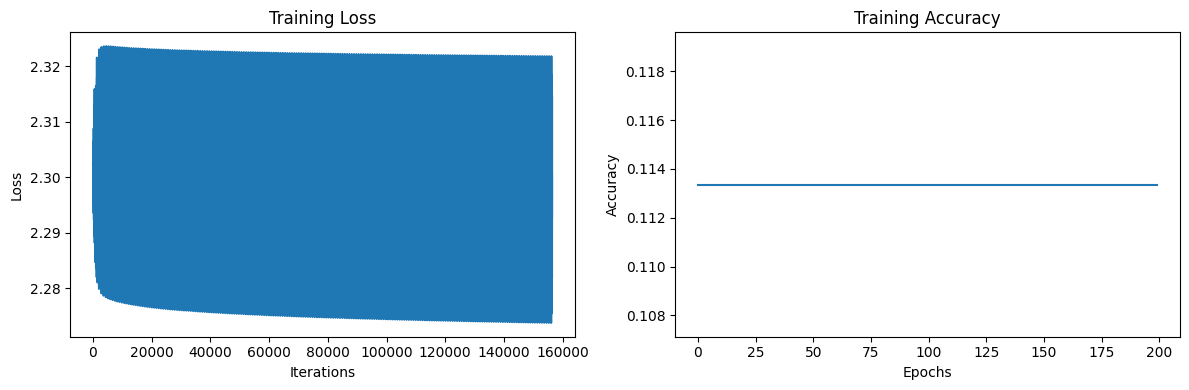

In [ ]:
learning_rate = 0.01
decay_rate = 0.1
epochs = 200
batch_size = 64

# Initialize weights with He initialization
W1 = he_init((input_size, hidden_size))
b1 = np.zeros((1, hidden_size))
W2 = he_init((hidden_size, output_size))
b2 = np.zeros((1, output_size))

# Training loop with mini-batch and learning rate decay
losses = []
accuracies = []

for epoch in range(epochs):
    # Learning rate decay
    current_lr = learning_rate / (1 + decay_rate * epoch)

    # Mini-batch training
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train_onehot[i:i+batch_size]

        # Forward propagation
        Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

        # Compute loss
        loss = cross_entropy_loss(y_batch, A2)
        losses.append(loss)

        # Backward propagation
        dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, Z2, A2, W1, W2)

        # Update weights and biases
        W1 -= current_lr * dW1
        b1 -= current_lr * db1
        W2 -= current_lr * dW2
        b2 -= current_lr * db2

    # Compute training accuracy for monitoring
    _, _, _, A2_train = forward_propagation(X_train, W1, b1, W2, b2)
    y_pred_train = np.argmax(A2_train, axis=1)
    y_true_train = np.argmax(y_train_onehot, axis=1)
    train_accuracy = np.mean(y_pred_train == y_true_train)
    accuracies.append(train_accuracy)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")

# Plotting
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


## Evaluation

In [ ]:
# Test the model
_, _, _, A2_test = forward_propagation(X_test, W1, b1, W2, b2)
y_pred = np.argmax(A2_test, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 96.54%
